In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True) #enables plotly plots to be displayed in notebook
cmap1 = "gist_gray"
import altair as alt
import country_converter as coco
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import missingno as msno
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [10]:
salaries = pd.read_csv('Downloads\\ds_salaries.csv')
df = salaries.copy()
display(df.head())

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [11]:
def check_data(df):
    print(80 * "*")
    print('DIMENSION: ({}, {})'.format(df.shape[0], df.shape[1]))
    print(80 * "*")
    print("COLUMNS:\n")
    print(df.columns.values)
    print(80 * "*")
    print("DATA INFO:\n")
    print(df.dtypes)
    print(80 * "*")
    print("MISSING VALUES:\n")
    print(df.isnull().sum())
    print(80 * "*")
    print("NUMBER OF UNIQUE VALUES:\n")
    print(df.nunique())
    
check_data(df)

********************************************************************************
DIMENSION: (3755, 11)
********************************************************************************
COLUMNS:

['work_year' 'experience_level' 'employment_type' 'job_title' 'salary'
 'salary_currency' 'salary_in_usd' 'employee_residence' 'remote_ratio'
 'company_location' 'company_size']
********************************************************************************
DATA INFO:

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object
********************************************************************************
MISSING VALUES:

work_year             0
experience_level      0
employment_type       0
job_title             0
salary  

In [13]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(" RESULT ".center(50, "-"))
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print("".center(50, "-"))
    
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

--------------------- RESULT ---------------------
Observations: 3755
Variables: 11
cat_cols: 6
num_cols: 2
cat_but_car: 3
num_but_cat: 2
--------------------------------------------------


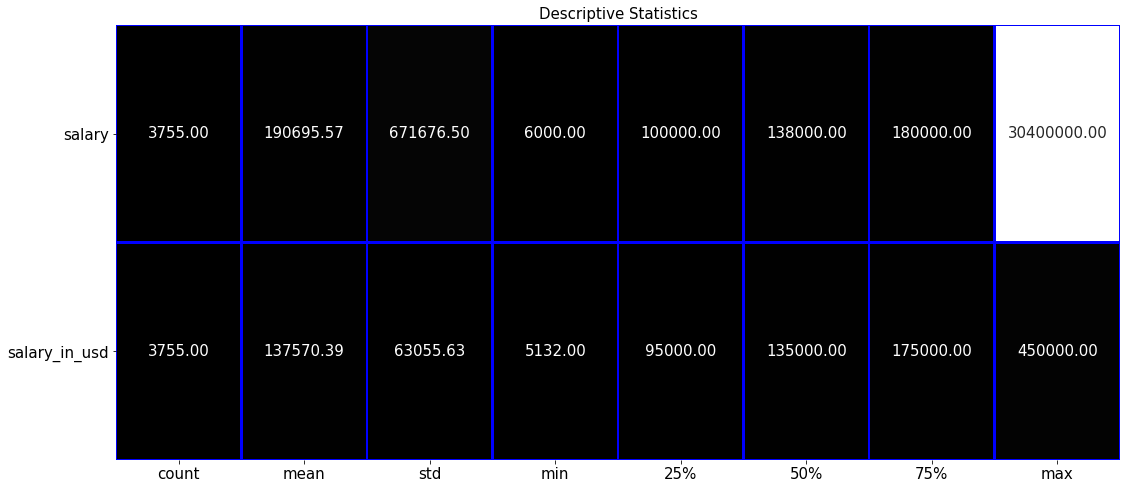

In [15]:
def descriptive_stats(df):
    desc = df.describe().T
    desc_df = pd.DataFrame(index = df. columns,
                          columns = desc.columns,
                          data = desc)
    f, ax = plt.subplots(figsize = (18, 8))
    sns.heatmap(desc,
               annot = True,
               cmap = cmap1,
               fmt = ".2f",
               ax = ax,
               linecolor = "blue",
               linewidths = 1.5,
               cbar = False,
               annot_kws = {"size" : 15})
    plt.xticks(size = 15)
    plt.yticks(size = 15, rotation = 0)
    plt.title("Descriptive Statistics", size = 15)
    plt.show()
    
   
descriptive_stats(df[num_cols])

In [16]:
def tar_var_summary(df, target):
    fig = go.Figure()
    fig.add_trace(go.Violin(x=df[target], line_color='#6C9BCF', name='Happy', y0=0))
    fig.update_traces(orientation='h', side='positive', meanline_visible=False)
    fig.update_layout(title={'text': "Distribution of the Target Variable",
                             'y':0.9,
                             'x':0.5,
                             'xanchor':'center',
                             'yanchor':'top'},
                             barmode='overlay',
                             yaxis=dict(title='Count'),
                             template = 'plotly_dark')
    fig.show()
    
tar_var_summary(df, "salary_in_usd")

In [17]:
def num_var_summary(df, num_var):
    fig = make_subplots(rows = 1, cols = 2,
                       subplot_titles = ("Quantiles", "Distribution"))
    
    fig.add_trace(go.Box(y = df[num_var],
                         name = str(num_var),
                         showlegend = False,
                         marker_color = "#A6D0DD"), 
                         row = 1, col = 1)
    
    fig.add_trace(go.Histogram(x = df[num_var],
                               xbins = dict(start = df[num_var].min(),
                                            end = df[num_var].max()),
                               showlegend = False,
                               name = str(num_var),
                               marker=dict(color="#0A4D68",
                                           line = dict(color = '#DBE6EC',
                                                       width = 1))
                              ),
                  row = 1, col = 2)
    
    fig.update_layout(title={'text': num_var.capitalize(),
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  template='plotly_dark')
    
    iplot(fig)

In [18]:
num_var_summary(df, "salary_in_usd")

In [19]:
def cat_var_summary(df, cat_var):
    colors = ['#a2b9bc', '#6b5b95', '#b2ad7f', '#feb236', '#b5e7a0', '#878f99',
              '#d64161', '#86af49', '#ff7b25']
    
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])
    
    x = [str(i) for i in df[cat_var].value_counts().index]
    y = df[cat_var].value_counts().values.tolist()
    
    fig.add_trace(go.Bar(x = x, y = y, text = y, 
                         textposition = "auto",
                       showlegend = False,
                        marker=dict(color=colors,
                              line = dict(color = 'black',
                                          width = 2))), row=1, col=1)
    
    fig.add_trace(go.Pie(labels = df[cat_var].value_counts().keys(),
                         values = df[cat_var].value_counts().values, 
                         hoverinfo ='label',
                  textinfo ='percent',
                  textfont_size = 20,
                  textposition ='auto',
                  marker=dict(colors=colors,
                              line = dict(color = 'black',
                                          width = 2))), row=1, col=2)

    
    fig.update_layout(title={'text': cat_var,
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  template='plotly_dark')
    
    iplot(fig)

In [20]:
cat_cols

['experience_level',
 'employment_type',
 'salary_currency',
 'company_size',
 'work_year',
 'remote_ratio']

In [21]:
for i in ["experience_level", "company_size", "work_year", "remote_ratio"]:
    cat_var_summary(df, i)

In [22]:
alt.Chart(df).mark_bar().encode(
    color=alt.Color('salary_in_usd', bin=True),
    x='count()',
    y='employment_type'
)

alt.Chart(...)

In [23]:
alt.Chart(df).mark_bar().encode(
    x='count()',
    y='salary_currency'
)

alt.Chart(...)

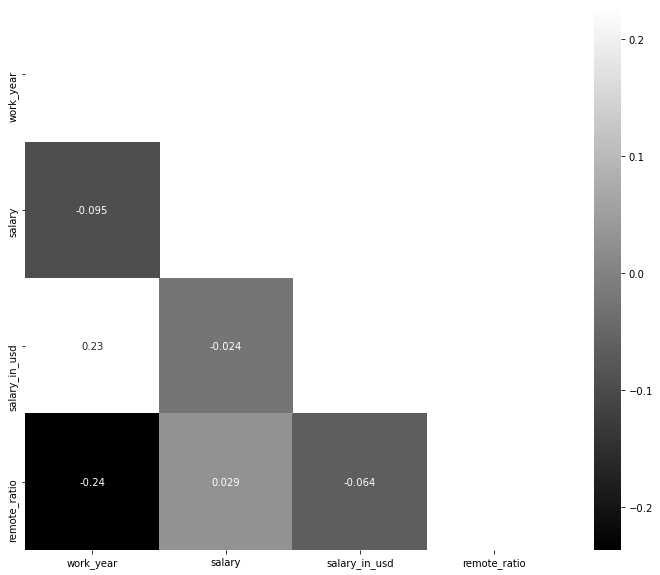

In [25]:
def df_corr(df):
    plt.figure(figsize = (12,10))
    corr = df.corr()
    matrix = np.triu(corr)
    sns.heatmap(corr, annot = True, mask = matrix, cmap = "gist_gray")
df_corr(df)

In [26]:
def detect_outliers(df, num_var):
    
    trace0 = go.Box(
        y = df[num_var],
        name = "All Points",
        jitter = 0.3,
        pointpos = -1.8,
        boxpoints = 'all',
        marker = dict(
            color = '#a2b9bc'),
        line = dict(
            color = '#6b5b95')
    )

    trace1 = go.Box(
        y = df[num_var],
        name = "Only Whiskers",
        boxpoints = False,
        marker = dict(
            color = '#b2ad7f'),
        line = dict(
            color = '#feb236')
    )

    trace2 = go.Box(
        y = df[num_var],
        name = "Suspected Outliers",
        boxpoints = 'suspectedoutliers',
        marker = dict(
            color = '#b5e7a0',
            outliercolor = '#878f99',
            line = dict(
                outliercolor = '#d64161',
                outlierwidth = 2)),
        line = dict(
            color = '#86af49')
    )

    trace3 = go.Box(
        y = df[num_var],
        name = "Whiskers and Outliers",
        boxpoints = 'outliers',
        marker = dict(
            color = '#6b5b95'),
        line = dict(
            color = '#ff7b25')
    )

    data = [trace0,trace1,trace2,trace3]

    layout = go.Layout(
        title = "{} Outliers".format(num_var)
    )
    
    layout = go.Layout(title={'text': num_var,
                         'y':0.9,
                         'x':0.5,
                         'xanchor':'center',
                         'yanchor':'top'},
                         barmode='overlay',
                         yaxis=dict(title='Count'),
                         template = 'plotly_dark')

    fig = go.Figure(data=data,layout=layout)
    
    iplot(fig)

In [27]:
detect_outliers(df, "salary_in_usd")

In [28]:
def display_topn_cat_val(df, feature, n=5):
    topn = df[feature].value_counts()[:n]
    fig = px.bar(y = topn.values, x = topn.index,  
            text = topn.values, title = 'Top {} Job Designations'.format(n))
    fig.update_layout(title={'text': feature,
                             'y':0.9,
                             'x':0.5,
                             'xanchor':'center',
                             'yanchor':'top'},
                             barmode='overlay',
                             yaxis=dict(title='Count'),
                             template = 'plotly_dark')
    fig.show()
display_topn_cat_val(df, 'job_title', n=10)

In [29]:
display_topn_cat_val(df, 'salary_currency')

In [30]:
df['experience_level'] = df['experience_level'].replace('EN','Entry-level/Junior')
df['experience_level'] = df['experience_level'].replace('MI','Mid-level/Intermediate')
df['experience_level'] = df['experience_level'].replace('SE','Senior-level/Expert')
df['experience_level'] = df['experience_level'].replace('EX','Executive-level/Director')

ex_level = df['experience_level'].value_counts()
fig = px.treemap(ex_level, path = [ex_level.index], values = ex_level.values, 
                title = 'Experience Level')
fig.update_layout(title={'text': "Experience Level Frequency",
                             'y':0.9,
                             'x':0.5,
                             'xanchor':'center',
                             'yanchor':'top'},
                             barmode='overlay',
                             yaxis=dict(title='Count'),
                             template = 'plotly_dark')
fig.show()

In [31]:
remote_year = df.groupby(['work_year','remote_ratio']).size()
ratio_2020 = np.round(remote_year[2020].values/remote_year[2020].values.sum(),2)
ratio_2021 = np.round(remote_year[2021].values/remote_year[2021].values.sum(),2)
ratio_2022 = np.round(remote_year[2022].values/remote_year[2022].values.sum(),2)
ratio_2023 = np.round(remote_year[2023].values/remote_year[2023].values.sum(),2)

fig = go.Figure()
categories = ['No Remote Work', 'Partially Remote', 'Fully Remote']
fig.add_trace(go.Scatterpolar(
            r = ratio_2020, theta = categories, 
            fill = 'toself', name = '2020 remote ratio'))

fig.add_trace(go.Scatterpolar(
            r = ratio_2021, theta = categories,
            fill = 'toself', name = '2021 remote ratio'))

fig.add_trace(go.Scatterpolar(
            r = ratio_2022, theta = categories,
            fill = 'toself', name = '2022 remote ratio'))

fig.add_trace(go.Scatterpolar(
            r = ratio_2023, theta = categories,
            fill = 'toself', name = '2023 remote ratio'))
fig.update_layout(title={'text': "Remote Ratio by Work Year",
                             'y':0.9,
                             'x':0.5,
                             'xanchor':'center',
                             'yanchor':'top'},
                             barmode='overlay',
                             yaxis=dict(title='Count'),
                             template = 'plotly_dark')
fig.show()


In [32]:
exp_level = df.groupby(['work_year','experience_level']).size()
ratio_2020 = np.round(exp_level[2020].values/exp_level[2020].values.sum(),2)
ratio_2021 = np.round(exp_level[2021].values/exp_level[2021].values.sum(),2)
ratio_2022 = np.round(exp_level[2022].values/exp_level[2022].values.sum(),2)
ratio_2023 = np.round(exp_level[2023].values/exp_level[2023].values.sum(),2)

fig = go.Figure()
categories = ['Entry-level/Junior', 'Mid-level/Intermediate', 'Senior-level/Expert', 
              'Executive-level/Director']
fig.add_trace(go.Scatterpolar(
            r = ratio_2020, theta = categories, 
            fill = 'toself', name = '2020 exp-level ratio'))

fig.add_trace(go.Scatterpolar(
            r = ratio_2021, theta = categories,
            fill = 'toself', name = '2021 exp-level ratio'))

fig.add_trace(go.Scatterpolar(
            r = ratio_2022, theta = categories,
            fill = 'toself', name = '2022 exp-level ratio'))

fig.add_trace(go.Scatterpolar(
            r = ratio_2023, theta = categories,
            fill = 'toself', name = '2023 exp-level ratio'))
fig.update_layout(title={'text': "Experience Level Ratio by Work Year",
                             'y':0.9,
                             'x':0.5,
                             'xanchor':'center',
                             'yanchor':'top'},
                             barmode='overlay',
                             yaxis=dict(title='Count'),
                             template = 'plotly_dark')
fig.show()

In [33]:
def disp_avg_score(df, feature, target):
    exp_avg = pd.DataFrame(df.groupby([target]).mean())
    exp_avg = exp_avg.reset_index()

    trace1 = go.Bar(x = exp_avg[target],
                    y = exp_avg[feature],
                    name = 'Salary in USD',
                    marker = dict(color ='#A6D0DD',
                                  opacity = 0.7))

    layout = go.Layout(title = 'Average Scores by Target Value',
                       barmode = 'stack',
                       xaxis = dict(title='Level of Experience'),
                       yaxis =dict(title='Salary ($)'),
                       template = 'plotly_dark')

    fig = go.Figure(data = [trace1], layout=layout)
    iplot(fig)
    
disp_avg_score(df, "salary_in_usd", "experience_level")

In [34]:
df['employment_type'] = df['employment_type'].replace('CT','Freelancer')
df['employment_type'] = df['employment_type'].replace('FL','Contractor')
df['employment_type'] = df['employment_type'].replace('FT','Full-time')
df['employment_type'] = df['employment_type'].replace('PT','Part-time')
disp_avg_score(df, "salary_in_usd", "employment_type")

In [35]:
df['company_size'] = df['company_size'].replace({
    'S': 'Small',
    'M': 'Medium',
    'L' : 'Large',
})
disp_avg_score(df, "salary_in_usd", "company_size")

In [36]:
country = coco.convert(names = df['employee_residence'], to = "ISO3")
df['employee_residence'] = country

residence = df['employee_residence'].value_counts()
fig = px.choropleth(locations = residence.index,
                    color = residence.values,
                    color_continuous_scale=px.colors.sequential.YlGn,
                    title = 'Employee Loaction On Map')
fig.show()